In [1]:
import IJulia
import Base64

# The julia kernel has built in support for Revise.jl, so this is the 
# recommended approach for long-running sessions:
# https://github.com/JuliaLang/IJulia.jl/blob/9b10fa9b879574bbf720f5285029e07758e50a5e/src/kernel.jl#L46-L51

# Users should enable revise within .julia/config/startup_ijulia.jl:
# https://timholy.github.io/Revise.jl/stable/config/#Using-Revise-automatically-within-Jupyter/IJulia-1

# clear console history
IJulia.clear_history()

fig_width = 7
fig_height = 5
fig_format = :retina
fig_dpi = 96

# no retina format type, use svg for high quality type/marks
if fig_format == :retina
  fig_format = :svg
elseif fig_format == :pdf
  fig_dpi = 96
  # Enable PDF support for IJulia
  IJulia.register_mime(MIME("application/pdf"))
end

# convert inches to pixels
fig_width = fig_width * fig_dpi
fig_height = fig_height * fig_dpi

# Intialize Plots w/ default fig width/height
try
  import Plots

  # Plots.jl doesn't support PDF output for versions < 1.28.1
  # so use png (if the DPI remains the default of 300 then set to 96)
  if (Plots._current_plots_version < v"1.28.1") & (fig_format == :pdf)
    Plots.gr(size=(fig_width, fig_height), fmt = :png, dpi = fig_dpi)
  else
    Plots.gr(size=(fig_width, fig_height), fmt = fig_format, dpi = fig_dpi)
  end
catch e
  # @warn "Plots init" exception=(e, catch_backtrace())
end

# Initialize CairoMakie with default fig width/height
try
  import CairoMakie

  # CairoMakie's display() in PDF format opens an interactive window
  # instead of saving to the ipynb file, so we don't do that.
  # https://github.com/quarto-dev/quarto-cli/issues/7548
  if fig_format == :pdf
    CairoMakie.activate!(type = "png")
  else
    CairoMakie.activate!(type = string(fig_format))
  end
  CairoMakie.update_theme!(resolution=(fig_width, fig_height))
catch e
    # @warn "CairoMakie init" exception=(e, catch_backtrace())
end
  
# Set run_path if specified
try
  run_path = "L3J1bi9tZWRpYS9hbGYvZGF0b3MvbWlzcmVwb3NpdG9yaW9zL2RvY2VuY2lhL2FwcmVuZGl6YWplLWF1dG9tYXRpY28tcHJhY3RpY2FzLWp1bGlh"
  if !isempty(run_path)
    run_path = String(Base64.base64decode(run_path))
    cd(run_path)
  end
catch e
  @warn "Run path init:" exception=(e, catch_backtrace())
end


# emulate old Pkg.installed beahvior, see
# https://discourse.julialang.org/t/how-to-use-pkg-dependencies-instead-of-pkg-installed/36416/9
import Pkg
function isinstalled(pkg::String)
  any(x -> x.name == pkg && x.is_direct_dep, values(Pkg.dependencies()))
end

# ojs_define
if isinstalled("JSON") && isinstalled("DataFrames")
  import JSON, DataFrames
  global function ojs_define(; kwargs...)
    convert(x) = x
    convert(x::DataFrames.AbstractDataFrame) = Tables.rows(x)
    content = Dict("contents" => [Dict("name" => k, "value" => convert(v)) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
elseif isinstalled("JSON")
  import JSON
  global function ojs_define(; kwargs...)
    content = Dict("contents" => [Dict("name" => k, "value" => v) for (k, v) in kwargs])
    tag = "<script type='ojs-define'>$(JSON.json(content))</script>"
    IJulia.display(MIME("text/html"), tag)
  end
else
  global function ojs_define(; kwargs...)
    @warn "JSON package not available. Please install the JSON.jl package to use ojs_define."
  end
end


# don't return kernel dependencies (b/c Revise should take care of dependencies)
nothing


In [2]:
function fibonacci(n::Int)
    a = zeros(Float32, n)
    a[1] = 1
    a[2] = 1
    for i in 3:n
        a[i] = a[i-1] + a[i-2]
    end
    return a
end

fibonacci (generic function with 1 method)

In [3]:
fib = fibonacci(30) 
ventana = 4
n = 30 - ventana
# La red esperar una entrada con dimensiones (características, ventana, lote).
X =  Array{Float32}(undef, 1, ventana, n)
Y = Array{Float32}(undef, 1, n)  
for i = 1:n
    serie = fib[i:i+ventana-1]
    etiqueta = fib[i+ventana]
    X[1, : , i] .= serie
    Y[1, i] = etiqueta
end

In [4]:
using Lux, Random

modelo = Chain(
    Recurrence(RNNCell(1 => 8, identity); return_sequence = false),
    Dense(8 => 1)
)

rng = Random.default_rng()
ps, st = Lux.setup(rng, modelo)

┌ Warning: `replicate` doesn't work for `TaskLocalRNG`. Returning the same `TaskLocalRNG`.
└ @ LuxCore ~/.julia/packages/LuxCore/qsnGJ/src/LuxCore.jl:18


((layer_1 = (weight_ih = Float32[-1.2549006; 0.8111279; … ; 0.49307716; -1.5045356;;], weight_hh = Float32[-0.5839946 -0.053655468 … -1.6673822 0.28892732; -0.19559522 -0.6123604 … -0.7907593 -0.13889225; … ; -0.25136188 -0.6010639 … -0.9649381 -0.16346523; -0.40488178 0.34104648 … -0.52399766 -0.08014383], bias_ih = Float32[-0.127918, -0.8672191, 0.027058572, -1.003618, -1.5940827, -0.6757528, 0.4518224, -0.4899946], bias_hh = Float32[-0.13070239, -0.79701775, 0.7499847, -1.2297041, -0.93309605, 0.38034472, 0.85725325, -0.73411226]), layer_2 = (weight = Float32[-0.043337908 -0.30518138 … 0.19378431 -0.5501773], bias = Float32[0.08621884])), (layer_1 = (rng = TaskLocalRNG(),), layer_2 = NamedTuple()))

In [5]:
using Statistics
function coste(ps, st, X, Y)
    ŷ, _ = modelo(X, ps, st)          # ŷ: (1, batch)
    return mean((ŷ .- Y).^2)
end

coste(ps, st, X, Y)

1.0949429f8

In [6]:
using Optimisers, Zygote
opt = Optimisers.setup(Optimisers.Adam(0.01f0), ps)

nepocas = 200
costes = []
for epoca in 1:nepocas
    # gradiente de la red con respecto a los parámetros
    gs = first(Zygote.gradient(p -> coste(p, st, X, Y), ps))
    opt, ps = Optimisers.update(opt, ps, gs) 
    push!(costes, coste(ps, st, X, Y))
    println("Época $epoca | coste = ", costes[end])
end

Época 1 | coste = 2.8901857e9


Época 2 | coste = 2.5536885e8
Época 3 | coste = 5.758772e8
Época 4 | coste = 1.5130986e9
Época 5 | coste = 9.1408006e8
Época 6 | coste = 1.1806003e8
Época 7 | coste = 9.226049e7
Época 8 | coste = 5.5721894e8
Época 9 | coste = 7.552164e8
Época 10 | coste = 4.9322032e8
Época 11 | coste = 1.2109025e8
Época 12 | coste = 5.003525e6
Época 13 | coste = 1.8120286e8
Época 14 | coste = 3.7704326e8
Época 15 | coste = 3.5865136e8
Época 16 | coste = 1.7100021e8
Época 17 | coste = 1.7680492e7
Época 18 | coste = 2.3837874e7
Época 19 | coste = 1.3638448e8
Época 20 | coste = 2.1308149e8
Época 21 | coste = 1.7693096e8
Época 22 | coste = 7.3618376e7
Época 23 | coste = 3.9600155e6
Época 24 | coste = 2.068705e7
Época 25 | coste = 8.507124e7
Época 26 | coste = 1.1796023e8
Época 27 | coste = 8.600592e7
Época 28 | coste = 2.7340524e7
Época 29 | coste = 11249.101
Época 30 | coste = 2.0718892e7
Época 31 | coste = 5.595188e7
Época 32 | coste = 6.428661e7
Época 33 | coste = 3.8810644e7
Época 34 | coste = 7.94754

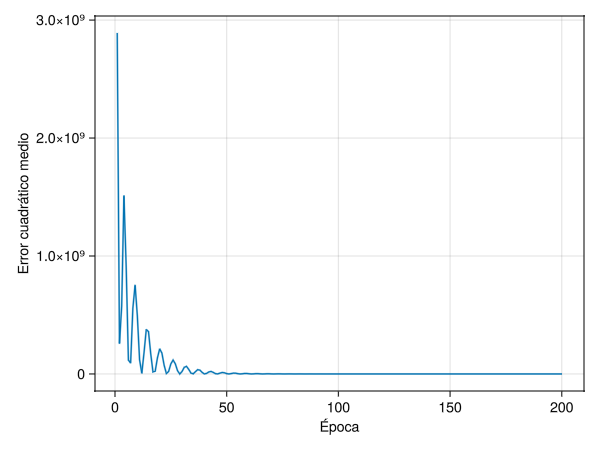

In [7]:
using GLMakie
fig = Figure()
ax = Axis(fig[1, 1], xlabel = "Época", ylabel = "Error cuadrático medio")
lines!(ax, costes)
fig

In [8]:
X_test = reshape(fib[end-ventana : end-1], 1, ventana, 1) 

y_test, _ = modelo(X_test, ps, st)
println("Predicción del término 30: ",  y_test[1, 1])

Predicción del término 30: 832045.9
